In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils

import optuna
from optuna.artifacts import upload_artifact
from optuna_dashboard import ChoiceWidget
from optuna_dashboard.artifact import get_artifact_path

/Applications/anaconda3/envs/optuna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## intitalise logging
# initiating the logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [ ]:
def get_mnist_loaders(train_batch_size, test_batch_size):

    """Get MNIST data loaders"""
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=train_batch_size, shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader

In [ ]:
#create the discriminator class

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=32*4*4, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # logging.info(f"Initial input shape: {x.size()}")
        x = F.relu(self.conv1(x))
        # logging.info(f"Input shape after 1st convolution: {x.size()}")
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        # logging.info(f"Input shape after 2nd convolution: {x.size()}")
        x = self.dropout2(x)
        x = F.relu(self.conv3(x))
        # logging.info(f"Input shape after 3rd convolution: {x.size()}")
        x = self.dropout3(x)
        x = x.view(-1, 32*4*4)
        # logging.info(f"Input shape after flattening: {x.size()}")
        x = self.fc1(x)
        # logging.info(f"Input shape after 1st linear layer: {x.size()}")
        x = self.sigmoid(x)
        # logging.info(f"Final input shape: {x.size()}")
        return x

In [ ]:
class generator(nn.Module):
    def __init__(self, latent_dim):
        super(generator, self).__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(latent_dim, 128*7*7)  # Adjusted linear layer to match the required feature map size
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # logging.info(f"Initial input shape: {x.size()}")
        x = self.fc1(x)
        # logging.info(f"Input shape after 1st linear layer: {x.size()}")
        x = x.view(-1, 128, 7, 7)  # Reshape to match the size after the last convolution in the discriminator
        # logging.info(f"Input shape after reshaping: {x.size()}")
        x = F.relu(self.conv_transpose1(x))
        # logging.info(f"Input shape after 1st transpose convolution: {x.size()}")
        x = self.conv_transpose2(x) # Using tanh as the final activation function
        # logging.info(f"Input shape after 2nd transpose convolution: {x.size()}")
        x = torch.tanh(x)
        # logging.info(f"Final input shape: {x.size()}")
        return x


In [ ]:
"""
Network Architectures
The following are the discriminator and generator architectures
"""

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [ ]:
cfg = {"train_batch_size": 128,
       "test_batch_size": 128,
       "device": "cuda" if torch.cuda.is_available() else "cpu",
       "num_epochs": 100,
       "lr": 2e-4,
       "betas":(0.5, 0.999),
       "latent_dim": 128}

In [ ]:
# Get a single batch image
train_loader, _ = get_mnist_loaders(train_batch_size=cfg['train_batch_size'], test_batch_size=cfg['test_batch_size'])
batch_images, _ = next(iter(train_loader))

In [ ]:
batch_images.shape

In [ ]:
# Instantiate the discriminator
discriminato = discriminator()

# Pass the image through the discriminator
output = discriminato(batch_images)

# Print the output
print("Discriminator output:", output)

In [ ]:
# Generate random noise
noise = torch.randn(cfg['train_batch_size'], cfg['latent_dim'])
print(f"noise shape: {noise.shape}")

# Instantiate the generator
generato = generator()

# Pass the noise through the generator
output = generato(noise)

# Print the output shape
print("Generator output shape:", output.shape)

In [ ]:
# # Define loss function and optimizer for both generator and discriminator
# criterion = nn.BCELoss()
# generator_optimizer = optim.Adam(generator.parameters(), lr=cfg['lr'], betas=cfg['betas'])
# discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=cfg['lr'], betas=cfg['betas'])

# # Training loop
# num_epochs = cfg['num_epochs']
# for epoch in range(num_epochs):
#     for real_images, _ in tqdm(train_loader):
#         # Train discriminator with real images
#         discriminator_optimizer.zero_grad()
#         real_outputs = discriminator(real_images)
#         real_loss = criterion(real_outputs, torch.ones_like(real_outputs))
        
#         # Generate fake images and train discriminator with them
#         noise = torch.randn(cfg['train_batch_size'], cfg['latent_dim'])
#         fake_images = generator(noise)
#         fake_outputs = discriminator(fake_images.detach())
#         fake_loss = criterion(fake_outputs, torch.zeros_like(fake_outputs))
        
#         discriminator_loss = real_loss + fake_loss
#         discriminator_loss.backward()
#         discriminator_optimizer.step()
        
#         # Train generator
#         generator_optimizer.zero_grad()
#         noise = torch.randn(cfg['train_batch_size'], cfg['latent_dim'])
#         fake_images = generator(noise)
#         fake_outputs = discriminator(fake_images)
#         generator_loss = criterion(fake_outputs, torch.ones_like(fake_outputs))
#         generator_loss.backward()
#         generator_optimizer.step()

#     # Print loss and other metrics
#     print(f'Epoch [{epoch+1}/{num_epochs}], '
#           f'Discriminator Loss: {discriminator_loss.item():.4f}, '
#           f'Generator Loss: {generator_loss.item():.4f}')
    
    # with torch.no_grad():
    #     fixed_noise = torch.randn(15, cfg['latent_dim'])  # Sample 15 images
    #     fake_images = generator(fixed_noise).detach().cpu()

    # plt.figure(figsize=(10, 10))
    # plt.axis("off")
    # plt.title("Generated Images")
    # plt.imshow(
    #     np.transpose(
    #         vutils.make_grid(fake_images, nrow=3, padding=1, normalize=True),
    #         (1, 2, 0)
    #     )
    # )
    # plt.show()


In [ ]:
"""
Determine if any GPUs are available
"""
device = cfg['device']
latent_dim = cfg['latent_dim']


"""
Hyperparameter settings
"""
epochs = cfg['num_epochs']
lr = cfg['lr']
batch_size = cfg['train_batch_size']
loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


"""
Image transformation and dataloader creation
Note that we are training generation and not classification, and hence
only the train_loader is loaded
"""
train_loader, _ = get_mnist_loaders(train_batch_size=cfg['train_batch_size'], test_batch_size=cfg['test_batch_size'])

In [ ]:
"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
"""
for epoch in range(epochs):

    logging.info(f"Runnning epoch {epoch+1}")
    for idx, (imgs, _) in tqdm(enumerate(train_loader)):
        idx += 1

        # Training the discriminator
        real_inputs = imgs.to(device)

        #real images are fed into discriminator, which gives a single output
        real_outputs = D(real_inputs)

        #this creates a real label of size of the batch with all label as 1 
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        #noise is created with dimension of the batch size and latent dimension equal to 128
        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5

        #noise saved to device
        noise = noise.to(device)

        #fake noice send to generator to generate images
        fake_inputs = G(noise)

        #that fake image is send to the discriminator to give the output
        fake_outputs = D(fake_inputs)

        #fake labels are createsd with 0s
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        
        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    with torch.no_grad():
        fixed_noise = torch.randn(15, 128)  # Sample 15 images
        fake_images = G(fixed_noise).detach().cpu()

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(fake_images, nrow=3, padding=1, normalize=True),
            (1, 2, 0)
        )
    )
    plt.show()

## Fresh Attempt to GANs

In [58]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [59]:
# More transforms can be added
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    MNIST('data/', download=True, transform=transform),
    batch_size=128,
    shuffle=True)

In [60]:
# Function to visualizing images from tensor

def show_tensor_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


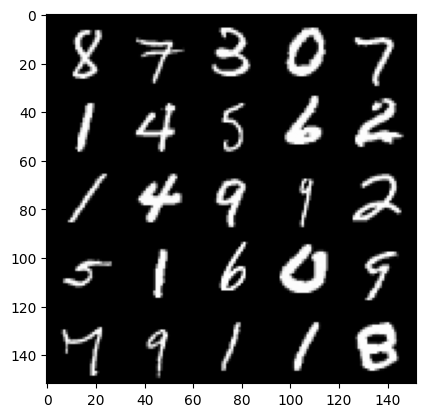

In [61]:
dataiter = iter(train_loader)
images,labels = next(dataiter)
print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

show_tensor_images(images)

In [62]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True),
        )

    def gen_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        '''
        Function that return a basic Sequential block for the Generator of DCGAN, corresponding to
            - Transposed Convolution
            - Batchnorm (except for in the last layer)
            - Activation
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, x):
        x = x.view(len(x), self.z_dim, 1, 1)      # change the shape: (batch_size, channels=z_dim, width=1, height=1)
        return self.gen(x)

In [63]:
class Discriminator(nn.Module):

    def __init__(self, img_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim, kernel_size=4),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=1),
            self.disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def disc_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        '''
        Function that return a basic Sequential block for the Discriminator of DCGAN, corresponding to
            - Convolution
            - Batchnorm (except for in the last layer)
            - LeakyReLU activation with 0.2 slope of the leak
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride)
            )
  
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [64]:
# required parameters for training

z_dim = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [65]:
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

G = G.apply(weights_init)
D = D.apply(weights_init)

In [66]:
beta_1 = 0.5         # parameters control the optimizer's momentum
beta_2 = 0.999       # parameters control the optimizer's momentum

G_opt = torch.optim.Adam(G.parameters(),lr=0.0002, betas=(beta_1, beta_2))
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(beta_1, beta_2))

# 'BinaryCrossEntropy Loss' is used to evaluate how well dicriminator and generator performs
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.zeros_like(disc_pred))
    return loss